<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/pi/lab4/exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import SVHN


torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [14]:
# exercise 1

X = torch.rand(1, 3, 8, 8)

K = torch.tensor([[[[0.0, 1.0], [2.0, 3.0]],
                   [[1.0, 2.0], [3.0, 4.0]],
                   [[7.0, 2.0], [3.0, 5.0]]]])

print(K)
F.conv2d(X, K)

tensor([[[[0., 1.],
          [2., 3.]],

         [[1., 2.],
          [3., 4.]],

         [[7., 2.],
          [3., 5.]]]])


tensor([[[[21.8731, 12.2356,  8.4167, 13.6668, 16.6758, 12.0738, 11.6168],
          [18.0115, 18.0818, 12.3743, 12.3275, 16.1960, 13.7414, 18.0475],
          [18.8897, 18.6871, 16.3429, 15.0494, 15.6963, 14.2775, 14.6295],
          [14.0591, 16.9760, 14.9938, 16.9809, 18.6053, 18.2793, 15.7961],
          [14.9409, 15.8543, 13.3501, 15.3347, 19.7120, 19.7734, 15.1883],
          [18.0112, 14.3470, 13.0526, 14.4105, 15.7873, 17.0078, 16.6179],
          [16.3281, 15.0334, 16.1681, 15.7792, 18.7729, 18.7911, 20.8385]]]])

In [100]:
# exercise 2

transform = transforms.Compose([
    transforms.ToTensor()
])

# Download the SVHN training dataset
svhn_train = SVHN(root='./data', split='train', download=True, transform=transform)
svhn_test = SVHN(root='./data', split='test', download=True, transform=transform)

total_train_samples = len(svhn_train)  # Should be 73,257

# Define split sizes
train_size = 43257
val_size = 30000

svhn_train_subset, svhn_val_subset = random_split(svhn_train, [train_size, val_size])

train_loader = DataLoader(svhn_train_subset, batch_size=256, shuffle=True)
val_loader = DataLoader(svhn_val_subset, batch_size=256, shuffle=False)
test_loader = DataLoader(svhn_test, batch_size=256, shuffle=False)

net = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.Sigmoid(), # 3 input channels
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 6 * 6, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [99]:
# train and plot functions

def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

def train_epoch(net, train_iter, loss, optimizer, device):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [101]:
# training the data

batch_size, lr, num_epochs = 256, 0.5, 5
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_loader, val_loader, test_loader, num_epochs, lr, try_gpu())

Training on cpu
Epoch 1, Train loss 2.26, Train accuracy 18.02, Validation loss 2.24, Validation accuracy 18.90
Epoch 2, Train loss 2.24, Train accuracy 18.33, Validation loss 2.24, Validation accuracy 18.90
Epoch 3, Train loss 2.24, Train accuracy 18.80, Validation loss 2.24, Validation accuracy 18.90
Epoch 4, Train loss 2.24, Train accuracy 18.91, Validation loss 2.24, Validation accuracy 18.90
Epoch 5, Train loss 2.24, Train accuracy 18.92, Validation loss 2.24, Validation accuracy 18.90
Test loss 2.22, Test accuracy 19.59


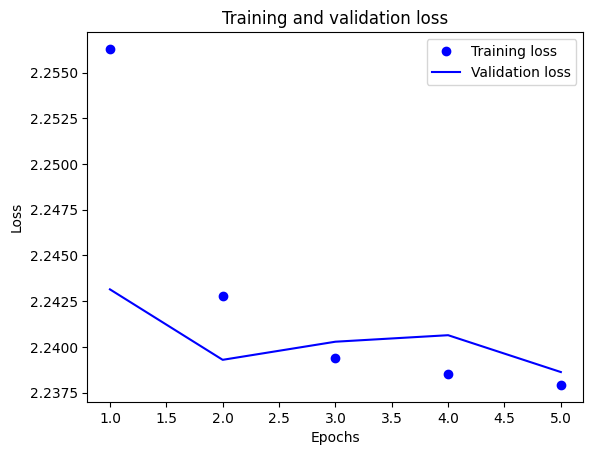

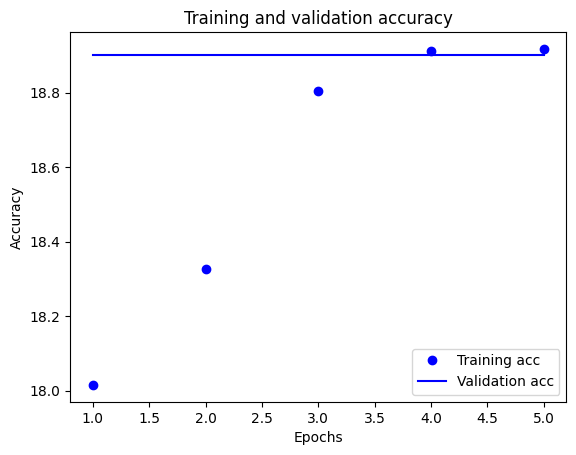

In [102]:
# plotting the data

plot_loss(train_loss_all, val_loss_all)
plot_accuracy(train_acc_all, val_acc_all)

In [103]:
# exercise 3

class CustomConvBlock(nn.Module):
    def __init__(self):
        super(CustomConvBlock, self).__init__()

        # Branch 1
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # Conv1
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # Conv2
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU()  # Activation
        )

        # Branch 2
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # Conv3
            nn.ReLU()  # Activation
        )

        # Flatten layer
        self.flatten = nn.Flatten()  # Layer to flatten the output before the linear layer

        # Fully connected layer
        self.fc = nn.Linear(64 * 32 * 32, 10)  # Adjust based on output size after branches

    def forward(self, x):
        # Pass input through branch 1
        out1 = self.branch1(x)

        # Pass through branch 2
        out2 = self.branch2(out1)

        # Add the outputs of both branches
        out = out1 + out2

        # Flatten the output
        out = self.flatten(out)  # Use the flatten layer

        # Fully connected layer
        out = self.fc(out)  # Output for classification

        return out

In [104]:
# training the data

batch_size, lr, num_epochs = 256, 0.05, 5
net = CustomConvBlock()
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_loader, val_loader, test_loader, num_epochs, lr, try_gpu())

Training on cpu
Epoch 1, Train loss 5.02, Train accuracy 18.46, Validation loss 2.22, Validation accuracy 19.80
Epoch 2, Train loss 2.14, Train accuracy 23.83, Validation loss 2.24, Validation accuracy 21.28
Epoch 3, Train loss 1.97, Train accuracy 33.63, Validation loss 1.82, Validation accuracy 39.52
Epoch 4, Train loss 1.80, Train accuracy 41.02, Validation loss 2.03, Validation accuracy 31.92
Epoch 5, Train loss 1.67, Train accuracy 46.64, Validation loss 1.79, Validation accuracy 42.30
Test loss 1.93, Test accuracy 39.82


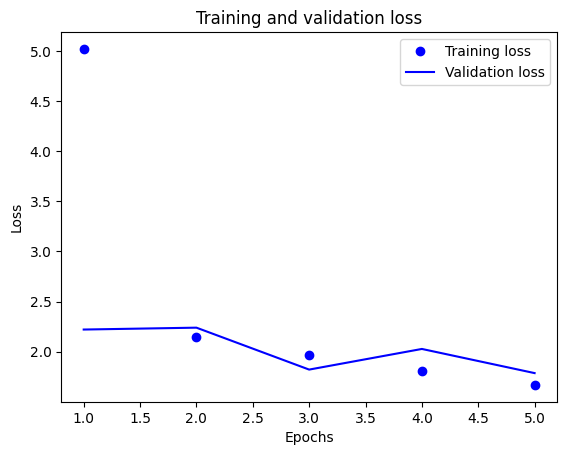

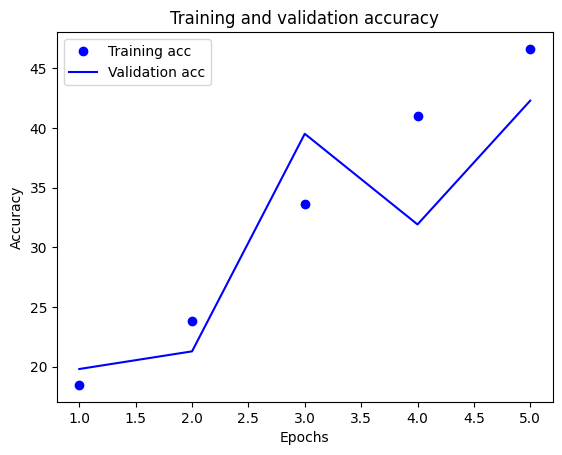

In [105]:
# plotting the data

plot_loss(train_loss_all, val_loss_all)
plot_accuracy(train_acc_all, val_acc_all)